# k-Fold Cross-Validation Work in the Presence of Outliers and High Leverage Samples?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define a ground truth generative function
def gen_func(n=1000000, n_predictors=5, p_leverage=0.001, mult_leverage=10, seed=42):
    np.random.seed(seed)
    coeffs = np.random.normal(0, 1, size=n_predictors)
    X = np.random.normal(0, 1, size=(n, n_predictors))

    # for each x_i, we randomly select p_leverage% and multiply by mult_leverage
    inds = np.random.choice(range(X.shape[0]), (int(X.shape[1]), int(X.shape[0]*p_leverage)))
    X[inds] = X[inds] * mult_leverage

    Y = 10 + X**2 @ coeffs + np.random.normal(0, 1) # make it squared
    return X, Y, coeffs

In [3]:
N = 1000000
N_train = 10000
X, Y, coeffs = gen_func(n=N, n_predictors=5, p_leverage=0.0001, mult_leverage=10, seed=42)
inds = np.arange(N)
np.random.seed(42)
np.random.shuffle(inds)
inds_train = inds[:N_train]
inds_test = inds[N_train:]

X_train = X[inds_train]
Y_train = Y[inds_train]

X_test = X[inds_test]
Y_test = Y[inds_test]

print(coeffs)
print(len(X_train), len(X_test))
print(len(Y_train), len(Y_test))

[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]
10000 990000
10000 990000


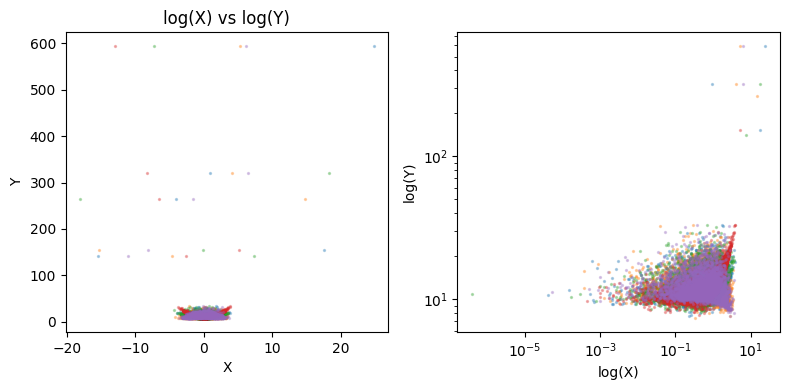

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(X_train.shape[1]):
    axs[0].scatter(X_train[:, i], Y_train, s=2, alpha=0.3)
    axs[0].set_ylabel("Y")
    axs[0].set_xlabel("X")
    axs[0].set_title("X vs Y")

    axs[1].scatter(X_train[:, i], Y_train, s=2, alpha=0.3)
    axs[1].loglog()
    axs[1].set_ylabel("log(Y)")
    axs[1].set_xlabel("log(X)")
    axs[0].set_title("log(X) vs log(Y)")    
plt.tight_layout()

In [39]:
# do standard k-fold cross validation
k_folds = 100
trials = 100

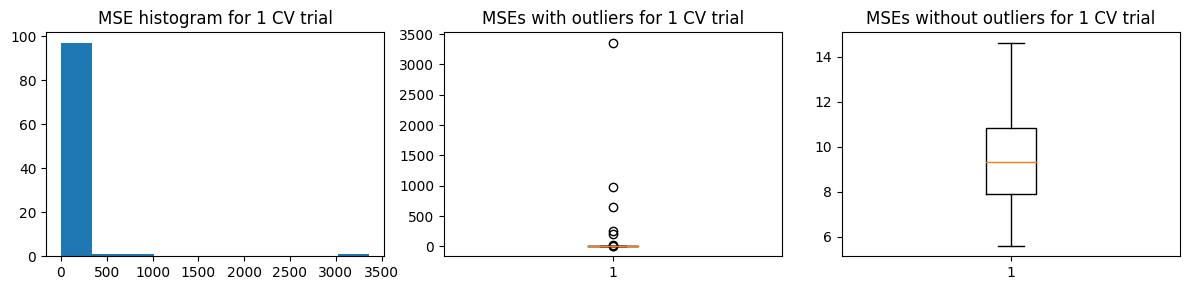

In [40]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

k_folds_idx = np.array(np.split(np.arange(len(X_train)), k_folds))
mse_means = []
mse_stds = []

np.random.seed(42)
for trial in range(trials):

    inds = np.arange(len(X_train))
    np.random.shuffle(inds)
    X_train_shuffled = X_train[inds]
    Y_train_shuffled = Y_train[inds]


    mse_list = []
    coeffs_list = []

    for k in range(k_folds):

        k_folds_idx_retain = np.delete(np.arange(k_folds), k)
        sample_idx_train = k_folds_idx[k_folds_idx_retain].flatten()
        sample_idx_valid = k_folds_idx[k].flatten()

        X_fold_train = X_train_shuffled[sample_idx_train]
        X_fold_valid = X_train_shuffled[sample_idx_valid]

        Y_fold_train = Y_train_shuffled[sample_idx_train]
        Y_fold_valid = Y_train_shuffled[sample_idx_valid]

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_fold_train, Y_fold_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_fold_valid)

        coeffs_list += [regr.coef_]
        mse_list += [mean_squared_error(Y_fold_valid, y_pred)]       

    coeffs_list = np.array(coeffs_list)
    mse_list = np.array(mse_list)    

    # compute the mean MSE from cross validation
    mse_mean = np.mean(mse_list)

    # compute the standard deviation
    mse_std = np.std(mse_list)    

    mse_means += [mse_mean]
    mse_stds += [mse_std]

    if trial == 0:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
        axs[0].hist(mse_list, cumulative=False)

        axs[1].boxplot(mse_list)
        axs[2].boxplot(mse_list, showfliers=False)

        axs[0].set_title("MSE histogram for 1 CV trial")        
        axs[1].set_title("MSEs with outliers for 1 CV trial")
        axs[2].set_title("MSEs without outliers for 1 CV trial")
        plt.tight_layout()
        plt.show()       

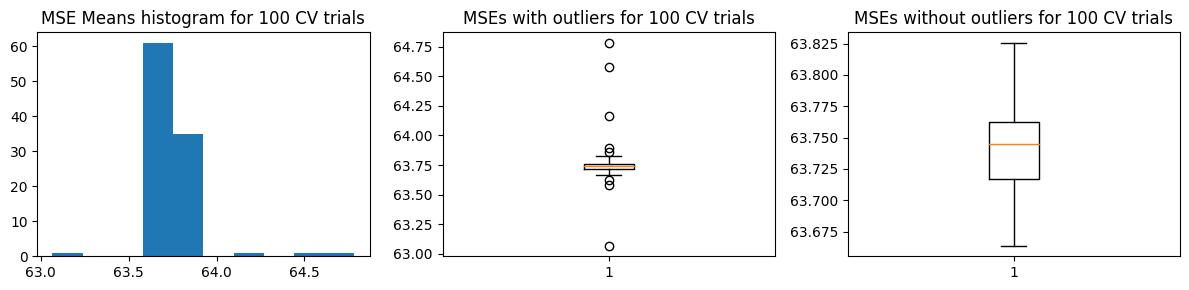

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
axs[0].hist(mse_means, cumulative=False)

axs[1].boxplot(mse_means)
axs[2].boxplot(mse_means, showfliers=False)

axs[0].set_title(f"MSE Means histogram for {trials} CV trials")        
axs[1].set_title(f"MSEs with outliers for {trials} CV trials")
axs[2].set_title(f"MSEs without outliers for {trials} CV trials")
plt.tight_layout()
plt.show()       

In [42]:
# compute the mean MSE from cross validation
mse_mean = np.mean(mse_means)

# compute the standard deviation
mse_std = np.std(mse_means)

# compute the true MSE from the test set when trained on the entire train set
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

mse_gt = mean_squared_error(Y_test, y_pred)

print("Mean MSE         ", mse_mean)
print("Std Dev MSE      ", mse_std)
print("Ground truth MSE ", mse_gt)

Mean MSE          63.75660471426123
Std Dev MSE       0.15955756270713287
Ground truth MSE  53.04536320061062


In [43]:
# the problem with k-fold CV is if you have rare outliers/high leverage points, 
# it's possible they get concentrated in one validation fold/group. 
# And this causes the distribution of errors to be highly skewed.
# once these points are chosen in one fold, they're no longer available for the other folds
# thus each k-fold becomes dependent on others, and no longer iid. This prevents us from computing say
# the standard error properly (which requires iid samples)

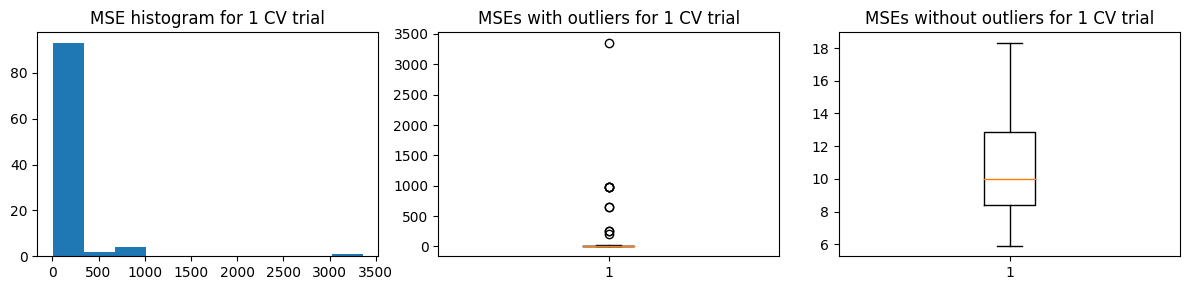

In [44]:
# what if instead of regular k-fold, we run simple train-valid set splits
# but run it 100 times, randomizing each time. With this, we make each validation MSE
# an iid sample

mse_means = []
mse_stds = []

for trial in range(trials):

    mse_list = []
    coeffs_list = []

    np.random.choice(42)
    for k in range(k_folds):

        sample_idx = np.arange(len(X_train))
        np.random.shuffle(sample_idx)
        train_idx = sample_idx[len(X_train)//k_folds:]
        valid_idx = sample_idx[:len(X_train)//k_folds]

        X_fold_train = X_train[train_idx]
        X_fold_valid = X_train[valid_idx]

        Y_fold_train = Y_train[train_idx]
        Y_fold_valid = Y_train[valid_idx]

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_fold_train, Y_fold_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_fold_valid)

        coeffs_list += [regr.coef_]
        mse_list += [mean_squared_error(Y_fold_valid, y_pred)]       

    coeffs_list = np.array(coeffs_list)
    mse_list = np.array(mse_list)    

    # compute the mean MSE from cross validation
    mse_mean = np.mean(mse_list)

    # compute the standard deviation
    mse_std = np.std(mse_list)    

    mse_means += [mse_mean]
    mse_stds += [mse_std]

    if trial == 0:
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
        axs[0].hist(mse_list, cumulative=False)

        axs[1].boxplot(mse_list)
        axs[2].boxplot(mse_list, showfliers=False)

        axs[0].set_title("MSE histogram for 1 CV trial")        
        axs[1].set_title("MSEs with outliers for 1 CV trial")
        axs[2].set_title("MSEs without outliers for 1 CV trial")
        plt.tight_layout()
        plt.show()       

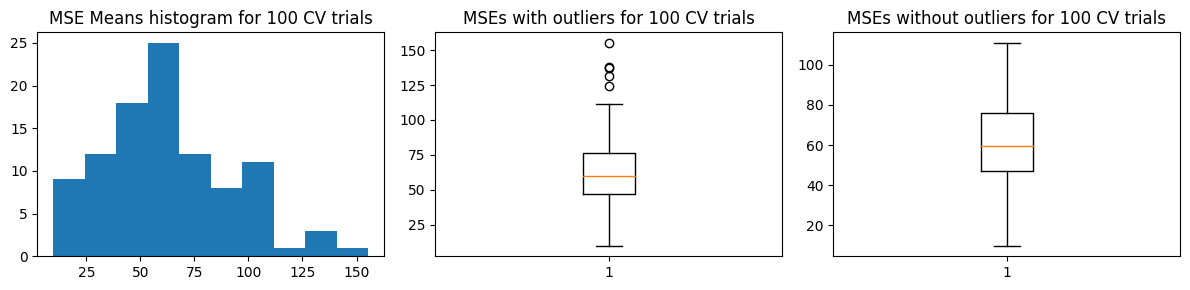

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))        
axs[0].hist(mse_means, cumulative=False)

axs[1].boxplot(mse_means)
axs[2].boxplot(mse_means, showfliers=False)

axs[0].set_title(f"MSE Means histogram for {trials} CV trials")        
axs[1].set_title(f"MSEs with outliers for {trials} CV trials")
axs[2].set_title(f"MSEs without outliers for {trials} CV trials")
plt.tight_layout()
plt.show()       

In [46]:
# compute the mean MSE from cross validation
mse_mean = np.mean(mse_means)

# compute the standard deviation
mse_std = np.std(mse_means)

# compute the true MSE from the test set when trained on the entire train set
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

mse_gt = mean_squared_error(Y_test, y_pred)

print("Mean MSE         ", mse_mean)
print("Std Dev MSE      ", mse_std)
print("Ground truth MSE ", mse_gt)

Mean MSE          62.99516870328772
Std Dev MSE       30.44480934715585
Ground truth MSE  53.04536320061062
